# Initializing

0.04591836734693877


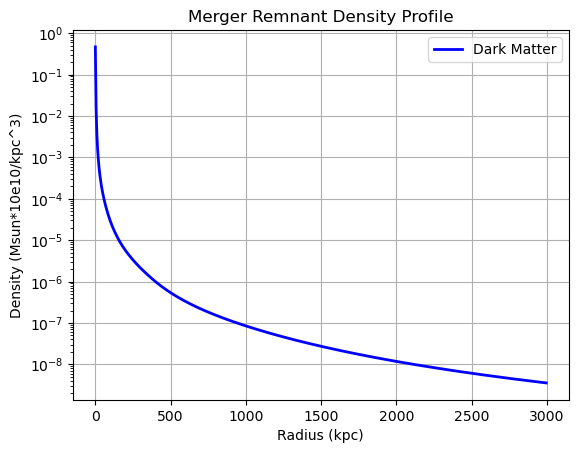

In [3]:
# Import Modules
import numpy as np
from astropy import units as u
from astropy import constants as const

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit

from ReadFile import Read
from CenterOfMass2 import CenterOfMass
from GalaxyMass import ComponentMass
from RemnantDensityProfile import Integrator
from RemnantDensityProfile import density

In [4]:
# Get file info
filename = "Merger_801.txt"
Remnant_t, Remnant_p, Remnant_d = Read(filename)

# Critical density of the universe in 10e10 M_Sun and kpc
pcrit = 1.277e-8 
r200 = 280.1

In [27]:
# Get density profile
# get COM of remnant
Remnant = CenterOfMass(filename, 1)

# Error tolerance
delta = 0.01
# Decrease volume factor
voldec = 2.0

# This is the center of mass of the remnant
Remnant_COMp = Remnant.COM_P(delta, voldec)

# Density Profile
Halo_density = density(280.1, .1)

# Part 2: Fit halo density profiles to MW/M31 remnant

Three profiles: NFW, Einasto, Hernquist

Steps:

1) Import remnant density profile
2) Fit NFW Profile

    a) Determine $r_{dm}, \rho_{dm}$
3) Fit Hernquist Profile

    a) Determine $M_{halo}$, $a$
4) Fit Einasto Profile
    
    a) Determine $\rho_{-2}$, $\alpha$, $r_{-2}$

    Note: Use $\frac{dlog(\rho)}{dlog(r)} = -2$

5) Perform least squared test to determine which fit has the least error

# Listing Functions

In [ ]:
def HernquistProfile(r, Mhalo, a):
    ''' 
    Hernquist profile format (see proposal)
    Inputs:
        r: variable
            Independent radius variable that density is dependent on
        Mhalo: parameter
            Mass of the dark matter halo
        a: paramater
            Scale length of remnant halo
    Outputs:
        func: function
            Hernquist profile function
    '''
    # Simplify
    numerator = Mhalo*a
    denom = 2*np.pi*r*(r+a)**3

    func = numerator/denom

    return func

In [7]:
def NFW1997(r, c, r_s):
    ''' 
    NFW profile format from 1997 paper
    Inputs:
        r: variable
            Independent radius variable that density is dependent on
        c: paramater
            Concentration of the dm halo
    Outputs:
        func: function
            NFW profile function
    '''
    gamma = 200/3 * c**3 * (np.log(1+c) -(c/(c+1)))**-1

    func = pcrit * gamma * (r/r_s)**-1 * (1+(r/r_s))**-2
    
    return func

# Fitting the curves

Note: Curve fit struggles with asymptotic behavior

In [108]:
# Fitting to our density profiles
# Hernquist
Hernpopt, Hernpcov = curve_fit(HernquistProfile, Halo_density[0], Halo_density[1], p0=(400, 10), maxfev=1500, bounds = ([0, 0], [1000, 100]))
Hern_fit = HernquistProfile(Halo_density[0], *Hernpopt)


In [109]:
print(Hernpopt)

[999.99999992  48.32962192]


In [ ]:
# NFW1997

NFW1997popt, NFW1997pcov = curve_fit(NFW1997, Halo_density[0], Halo_density[1], p0=(1,40000), bounds = ([-100, 0], [100, 1000000]), maxfev=2500)
NFW1997_fit = NFW1997(Halo_density[0], *NFW1997popt)

In [102]:
print(NFW1997popt)

[2.36022535e-01 1.27132528e+05]


# Checking Errors

In [126]:
# Hernquist error
print("Parameter value", Hernpopt)
Hernerr = np.sqrt(np.diag(Hernpcov))
print("Parameter Error:", Hernerr)
Herndif = Halo_density[1] - Hern_fit
chisqHern = np.array([])
for i in Hernerr:
    chii = 0
    chii = np.sum((Herndif/i)**2)
    chisqHern = np.append(chisqHern, chii)
print("Chi-squared for Hern", chisqHern)

Parameter value [999.99999992  48.32962192]
Parameter Error: [673.89114559  16.42086344]
Chi-squared for Hern [7.22382333e-07 1.21661912e-03]


In [127]:
# NFW1997
print("Parameter value", NFW1997popt)
NFW1997err = np.sqrt(np.diag(NFW1997pcov))
print("Parameter Error:", NFW1997err)
NFW1997dif = Halo_density[1] - NFW1997_fit
chisqNFW1997 = np.array([])
for i in NFW1997err:
    chii = 0
    chii = np.sum((NFW1997dif/i)**2)
    chisqNFW1997 = np.append(chisqNFW1997, chii)
print("Chi-squared for Hern", chisqNFW1997)

Parameter value [2.36022535e-01 1.27132528e+05]
Parameter Error: [3.53499144e+01 2.39749514e+07]
Chi-squared for Hern [2.49203811e-04 5.41771234e-16]


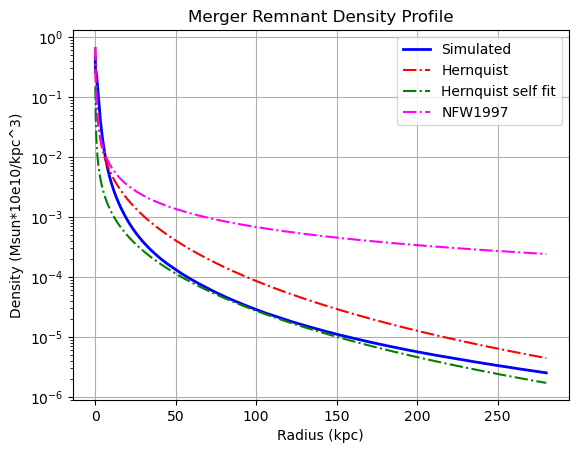

In [103]:
# Plotting
fig, ax = plt.subplots()
# Simulated Density profile
ax.plot(Halo_density[0], Halo_density[1], 'b', linewidth = 2, label='Simulated')

# Henrquist fit
ax.plot(Halo_density[0], Hern_fit, color = 'r', label='Hernquist', linestyle='-.')

ax.plot(Halo_density[0], HernquistProfile(Halo_density[0], 1600, 130), color = 'g', label='Hernquist self fit', linestyle='-.')

# NFW1997 fit
ax.plot(Halo_density[0], NFW1997_fit, color = 'magenta', label='NFW1997', linestyle='-.')

# Formatting
ax.set_yscale('log')
ax.grid()
ax.set(title='Merger Remnant Density Profile', xlabel='Radius (kpc)', ylabel='Density (Msun*10e10/kpc^3)')
ax.legend(loc='best')

plt.show()